In [1]:
from typing import List, Mapping
from itertools import zip_longest, chain
from glob import iglob
from pickle import load
from functools import partial, reduce

from numba import jit
from scipy.ndimage.filters import gaussian_filter
import pandas as pd
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from h5py import File
import altair as alt

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)


alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [4]:
filenames = [
    "Data/reduced_per/274-283_1_66.h5",
]


def read_file(filename):
    try:
        with File(filename, "r") as f:
            imgs = f['/vmi/data'][...].astype('float')
            n = f['/signal_shots'][...]
            delays = f['/IR_delays'][...]
            atmax = f['/peak_wavelengths'][...]
            i0, i1, ix, iy = imgs.shape
            indexes = (delays * atmax.T).reshape(-1)
    except KeyError:
        print("Got an error at: {}".format(filename))
        return None
    ret = pd.DataFrame({
        'sum': [img for img in (imgs * n[:, :, None, None]).reshape(-1, ix, iy)],
        'count': n.reshape(-1),
    }, index=pd.MultiIndex.from_product(
        [delays.reshape(-1), atmax.reshape(-1)],
        names=['delay_float', 'atmax_float'],
    ))
    where = ret['count'] != 0
    return ret[where]


sumup = partial(reduce, partial(pd.DataFrame.add, fill_value=0))
summed_flatten = sumup(read_file(fn) for fn in filenames)
summed_flatten.reset_index(inplace=True)

In [5]:
@jit
def bin_delays(d):
    step = 0.02  # Check delay step!
    centers = np.arange(-10, 0, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


@jit
def bin_atmax(d):
    step = 0.02  # Check delay step!
    centers = np.arange(75, 85, step)
    bins = (centers[1:] + centers[:-1]) / 2
    return centers.item(np.digitize(d, bins=bins))


summed_flatten['delay'] = summed_flatten['delay_float'].apply(bin_delays)
summed_flatten['atmax'] = summed_flatten['atmax_float'].apply(bin_atmax)
summed_all = summed_flatten.groupby(['delay', 'atmax'])[['sum', 'count']].apply(sum)
summed_all[['count']].head()

count
delay atmax        
-7.80 80.66  1666.0
-7.78 80.66  1667.0
-7.76 80.66  1667.0
-7.72 80.66  1607.0
-7.70 80.66  1606.0

In [6]:
summed = summed_all
df = pd.DataFrame({
    'img': (summed['sum'] / summed['count']).apply(partial(np.einsum, 'ij->ji')),
    'n': summed['count'],
})
df[["n"]].head()

n
delay atmax        
-7.80 80.66  1666.0
-7.78 80.66  1667.0
-7.76 80.66  1667.0
-7.72 80.66  1607.0
-7.70 80.66  1606.0

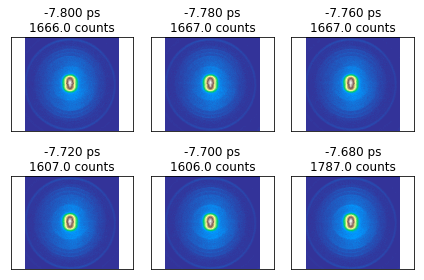

In [7]:
plt.figure()
for i, ((dt, atmax), img, n) in enumerate(df[['img', 'n']].itertuples()):
    if 6 <= i:
        break
    plt.subplot(2, 3, i+1)
    plt.title(f"{dt:.3f} ps\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

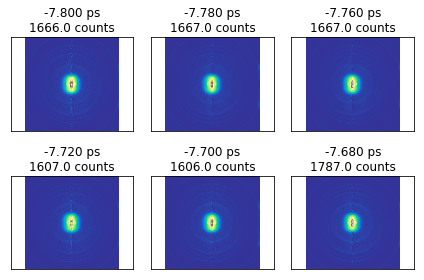

In [8]:
zedges = np.arange(-400, 400 + 1)
redges, thedges = np.linspace(0, 400, 400 + 1), np.linspace(-np.pi, np.pi, 360 + 1)
r = (redges[1:] + redges[:-1]) / 2
th = (thedges[1:] + thedges[:-1]) / 2


def invert_img(d):
    img = d['img']
    img = gaussian_filter(img, 2)
    xn, yn = img.shape
    xedges = np.arange(xn + 1)
    yedges = np.arange(yn + 1)
    f = interp(img, xedges, yedges)
    g = transpose_linearly(f, np.eye(2), x0=np.array([437, 458]))
    transformed = tohist(g, zedges, zedges)

    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(transpose_to_drdomega(sliced), redges, thedges)  # (r, th) -> intensity
    hist_indrdth = tohist(transpose_to_drdth(sliced), redges, thedges)  # (r, th) -> intensity
    return pd.Series({
        'inverted': inverted,
        'hist_indrdth': hist_indrdth,
        'hist_indrdomega': hist_indrdomega,
    })


if 'inverted' in df:
    df = df.drop(columns=['inverted', 'hist_indrdth', 'hist_indrdomega'])
df = df.merge(df.apply(invert_img, axis=1), left_index=True, right_index=True)


plt.figure()
for i, ((dt, atmax), img, n) in enumerate(df[['inverted', 'n']].itertuples()):
    if 6 <= i:
        break
    plt.subplot(2, 3, i+1)
    plt.title(f"{dt:.3f} ps\n{n} counts")
    plt.pcolormesh(img.T, cmap='terrain')
    plt.axis("equal")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.clim(0, None)
plt.tight_layout()
plt.show()

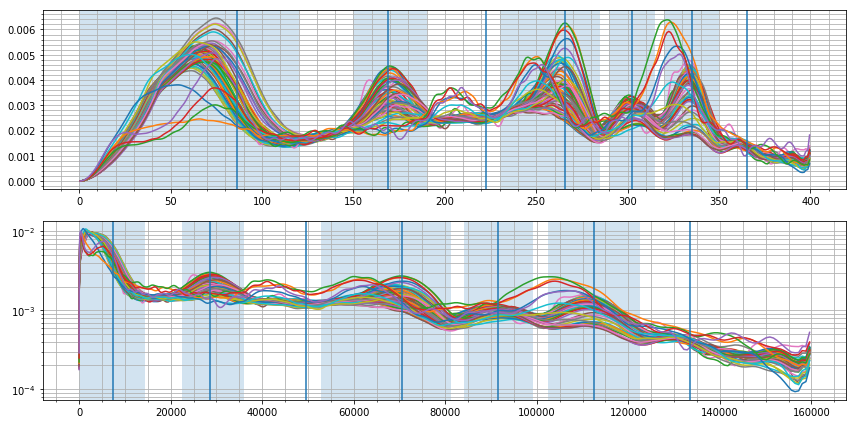

In [9]:
roi = {
    "a1": (0, 120),
    "x4": (150, 190),
    "x2": (230, 285),
    "x1": (290, 315),
    "x0": (320, 350),
}


def intergrateit(hist, fr, to, x=None, **kwargs):
    if x is None:
        x = np.arange(len(hist))
    where = (fr < x) & (x < to)
    return hist[where].sum(**kwargs)


def project_to_pn(hist, n):
    _, coeff, _ = finite_legendre_transform_in_theta(
        hist, thedges, n + 1,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return coeff[n]/coeff[0]


def norm(arr):
#     return arr
    return arr/arr.sum()


for k, (fr, to) in roi.items():
    df[f'summed_{k}_rdist'] = df['hist_indrdth'].apply(intergrateit, fr=fr, to=to, x=r)
    df[f'summed_{k}_pad'] = df['hist_indrdomega'].apply(intergrateit, fr=fr, to=to, x=r, axis=0)
    df[f'summed_{k}_beta2'] = df[f'summed_{k}_pad'].apply(project_to_pn, n=2)
    df[f'summed_{k}_beta4'] = df[f'summed_{k}_pad'].apply(project_to_pn, n=4)


def f(hist):
    return hist.sum(1)


plt.figure(figsize=(12, 6))
plt.subplot(211)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r, norm(dist))
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi.values():
    plt.axvspan(fr, to, alpha=0.2)

for i in range(-1, 6):
    plt.axvline((112500-21000*i)**0.5)

plt.subplot(212)
for (dt, atmax), dist in df['hist_indrdth'].apply(f).items():
    plt.plot(r**2, norm(dist/2/r))
plt.yscale("log")
plt.minorticks_on()
plt.grid(True, which='both')

for fr, to in roi.values():
    plt.axvspan(fr**2, to**2, alpha=0.2)

for i in range(-1, 6):
    plt.axvline(112500-21000*i)
plt.tight_layout()
plt.show()

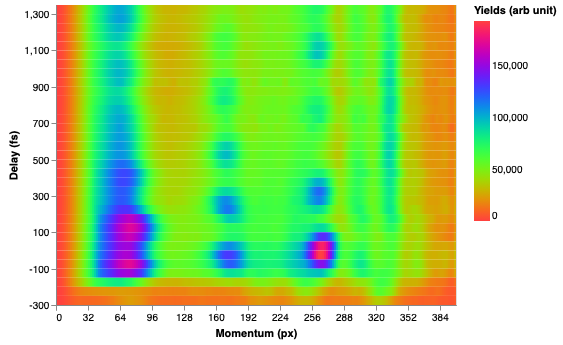

In [32]:
x, y = np.meshgrid(r, -df.index.to_frame()["delay"])
z = np.stack(df['hist_indrdth']).sum(2)
src = pd.DataFrame({
    "Momentum (px)": x.ravel(),
    "Delay (fs)": 1000 * (y.ravel() - 6.5),
    "Yields": z.ravel(),
})

alt.Chart(src).mark_rect().encode(
    alt.X("Momentum (px):Q", bin=alt.Bin(maxbins=200),
          axis=alt.Axis(title="Momentum (px)")),
    alt.Y("Delay (fs):Q", bin=alt.Bin(maxbins=65),
          axis=alt.Axis(title="Delay (fs)")),
    alt.Color(
        "mean(Yields):Q",
        title="Yields (arb unit)",
        scale=alt.Scale(
            zero=True, nice=False,
            scheme="sinebow",
        ),
    ),
)

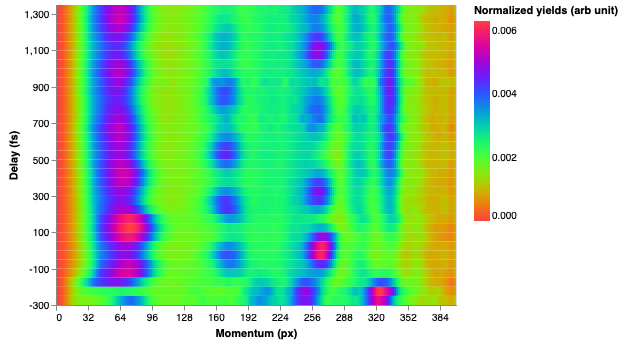

In [33]:
x, y = np.meshgrid(r, -df.index.to_frame()["delay"])
mat = np.stack(df['hist_indrdth'])  # Shape: (Delay, Momentum, Ang)
z = mat.sum(2) / mat.sum((1, 2))[:, None]
src = pd.DataFrame({
    "Momentum (px)": x.ravel(),
    "Delay (fs)": 1000 * (y.ravel() - 6.5),
    "Yields": z.ravel(),
})

alt.Chart(src).mark_rect().encode(
    alt.X("Momentum (px):Q", bin=alt.Bin(maxbins=200),
          axis=alt.Axis(title="Momentum (px)")),
    alt.Y("Delay (fs):Q", bin=alt.Bin(maxbins=65),
          axis=alt.Axis(title="Delay (fs)")),
    alt.Color(
        "mean(Yields):Q",
        title="Normalized yields (arb unit)",
        scale=alt.Scale(
            zero=True, nice=False,
            scheme="sinebow",
        ),
    ), 
)

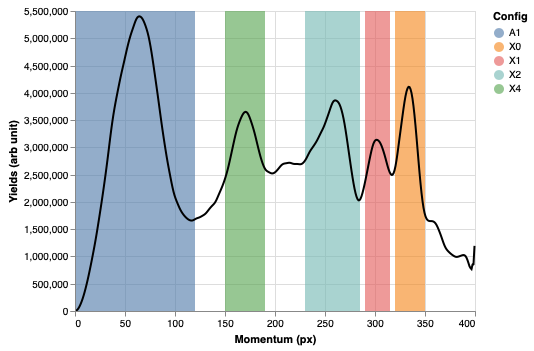

In [34]:
src = pd.DataFrame({
    "Momentum (px)": r,
    "Yields": df['hist_indrdth'].iloc[:-16].sum().sum(1),
})

roi = pd.DataFrame.from_dict({
    "A1": {"From": 0, "To": 120},
    "X4": {"From": 150, "To": 190},
    "X2": {"From": 230, "To": 285},
    "X1": {"From": 290, "To": 315},
    "X0": {"From": 320, "To": 350},
}, orient="index").rename_axis("Config").reset_index()

alt.Chart(roi).mark_rect(opacity=0.6).encode(
    x="From:Q",
    x2="To:Q",
    color="Config:N",
) + alt.Chart(src).mark_line(color="black").encode(
    alt.X("Momentum (px):Q", axis=alt.Axis(title="Momentum (px)")),
    alt.Y("Yields:Q",
          axis=alt.Axis(title="Yields (arb unit)")),
)

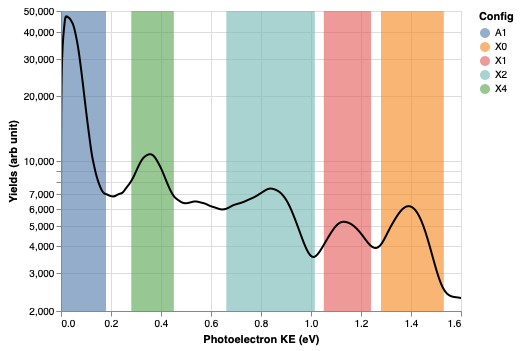

In [35]:
def calib(r):
    return r ** 2 / 80000


src = pd.DataFrame({
    "Photoelectron KE (eV)": calib(r),
    "Yields": df['hist_indrdth'].iloc[:-16].sum().sum(1) / 2 / r,
})

roi = (
    pd.DataFrame.from_dict({
        "A1": {"From": 0, "To": 120},
        "X4": {"From": 150, "To": 190},
        "X2": {"From": 230, "To": 285},
        "X1": {"From": 290, "To": 315},
        "X0": {"From": 320, "To": 350},
    }, orient="index")
    .apply(calib)
    .rename_axis("Config")
    .reset_index()
)

guide = pd.DataFrame({"Guide": np.arange(1.4, 0, -0.26)})

# alt.Chart(guide).mark_rule().encode(
#     x="Guide:Q",
# ) 

alt.Chart(roi).mark_rect(opacity=0.6).encode(
    x="From:Q",
    x2="To:Q",
    color="Config:N",
) + alt.Chart(src).mark_line(color="black").encode(
    alt.X("Photoelectron KE (eV):Q",
          axis=alt.Axis(title="Photoelectron KE (eV)"),
          scale=alt.Scale(domain=[0, 1.6])),
    alt.Y("Yields:Q",
          axis=alt.Axis(title="Yields (arb unit)"),
          scale=alt.Scale(type="log", domain=[2e3, 5e4], nice=False)),
).interactive(bind_x=False)

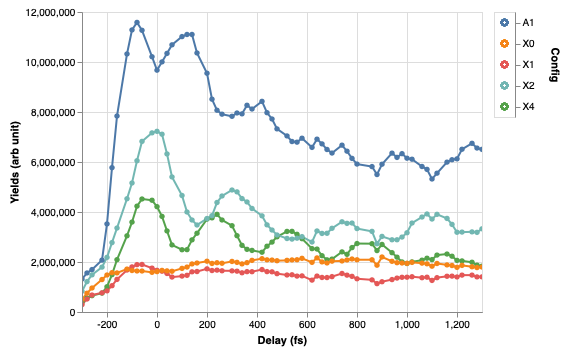

In [36]:
df["Delay (fs)"] = 1000 * (-df.index.to_frame()["delay"] - 6.5)
src = (
    df
    [[
        'Delay (fs)',
        'summed_a1_rdist',
        'summed_x4_rdist',
        'summed_x2_rdist',
        'summed_x1_rdist',
        'summed_x0_rdist',
    ]]
    .rename(columns={
        "summed_a1_rdist": "A1",
        "summed_x4_rdist": "X4",
        "summed_x2_rdist": "X2",
        "summed_x1_rdist": "X1",
        "summed_x0_rdist": "X0",
    })
    .melt("Delay (fs)", var_name="Config", value_name="Yields")
)
src_yields = src.set_index(["Config", "Delay (fs)"])

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Yields:Q",
          axis=alt.Axis(title="Yields (arb unit)")),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    y=alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend

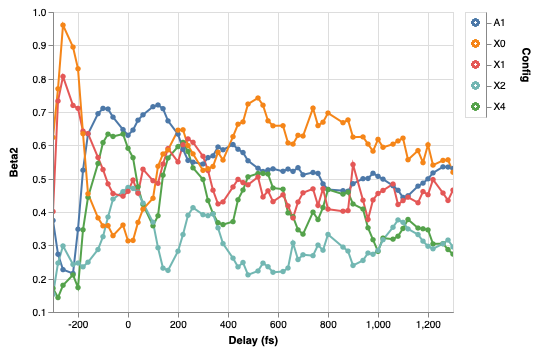

In [37]:
df["Delay (fs)"] = 1000 * (-df.index.to_frame()["delay"] - 6.5)
src = (
    df
    [[
        'Delay (fs)',
        'summed_a1_beta2',
        'summed_x4_beta2',
        'summed_x2_beta2',
        'summed_x1_beta2',
        'summed_x0_beta2',
    ]]
    .rename(columns={
        "summed_a1_beta2": "A1",
        "summed_x4_beta2": "X4",
        "summed_x2_beta2": "X2",
        "summed_x1_beta2": "X1",
        "summed_x0_beta2": "X0",
    })
    .melt("Delay (fs)", var_name="Config", value_name="Beta2")
)
src_beta2 = src.set_index(["Config", "Delay (fs)"])

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Beta2:Q", scale=alt.Scale(domain=[0.1, 1], nice=False)),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    y=alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend

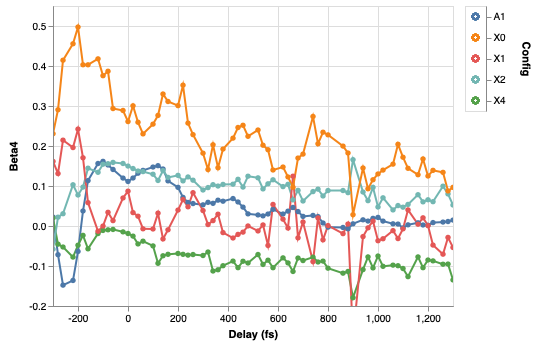

In [38]:
df["Delay (ps)"] = 1000 * (-df.index.to_frame()["delay"] - 6.5)
src = (
    df
    [[
        'Delay (fs)',
        'summed_a1_beta4',
        'summed_x4_beta4',
        'summed_x2_beta4',
        'summed_x1_beta4',
        'summed_x0_beta4',
    ]]
    .rename(columns={
        "summed_a1_beta4": "A1",
        "summed_x4_beta4": "X4",
        "summed_x2_beta4": "X2",
        "summed_x1_beta4": "X1",
        "summed_x0_beta4": "X0",
    })
    .melt("Delay (fs)", var_name="Config", value_name="Beta4")
)
src_beta4 = src.set_index(["Config", "Delay (fs)"])

select = alt.selection_multi(fields=['Config'])
color = alt.condition(select, alt.Color("Config:N", legend=None), alt.value('lightgray'))
main = alt.Chart(src).mark_line(point=True).encode(
    alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
    alt.Y("Beta4:Q", scale=alt.Scale(domain=[-0.2, 0.55], nice=False)),
    color=color,
).interactive(bind_x=False)
legend = alt.Chart(src).mark_point().encode(
    y=alt.Y("Config:N", axis=alt.Axis(orient="right")),
    color=color,
).add_selection(select)

main | legend

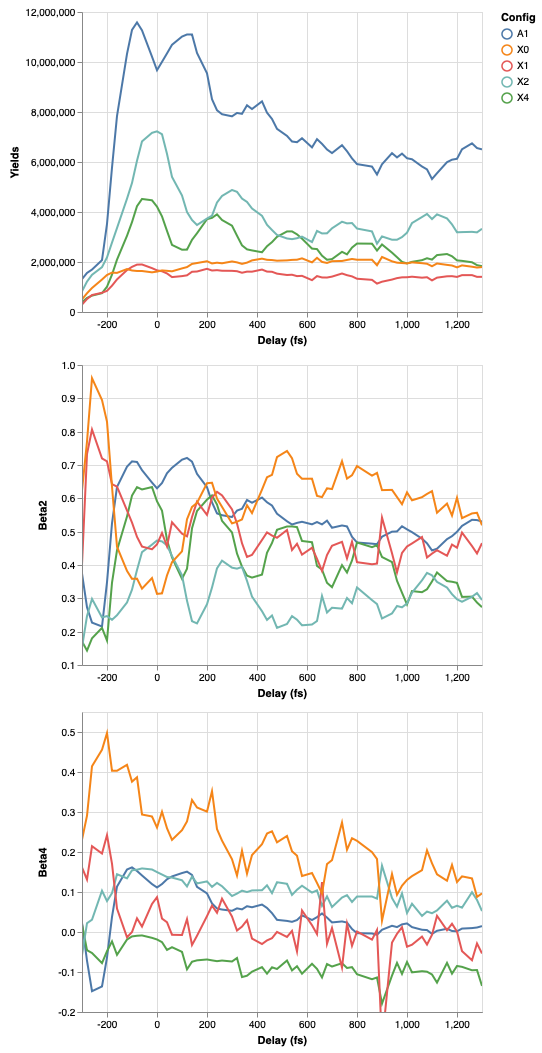

In [41]:
src = pd.concat([src_yields, src_beta2, src_beta4], axis=1)
base = alt.Chart(src.reset_index()).mark_line()
(
    base.encode(
        alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
        alt.Y("Yields:Q"),
        alt.Color("Config:N"),
    ).interactive(bind_x=False)
    & base.encode(
        alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
        alt.Y("Beta2:Q", scale=alt.Scale(zero=False)),
        alt.Color("Config:N"),
    ).interactive(bind_x=False)
    & base.encode(
        alt.X("Delay (fs):Q", scale=alt.Scale(zero=False, nice=False)),
        alt.Y("Beta4:Q", scale=alt.Scale(domain=[-0.2, 0.55], nice=False)),
        alt.Color("Config:N"),
    ).interactive(bind_x=False)
)